# Temperture Analysis 

### Purpose
This notebook will look at comparing the usability of temperature readings between Christmas Bird Count Volunteers and NOAA Weather Stations.

### Author: 
Jacob Ellena
### Date: 
2020-07-30
### Update Date: 
2020-07-30

### Inputs 
1.3-rec-connecting-fips-ecosystem-data.txt -  
Example
cbc_effort_weather_1900-2018.txt - Tab seperated file of Christmas Bird Count events going back to 1900. Each row represents a single count in a given year. Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
None

## Steps or Proceedures in the notebook 
Comparisons are split into the following sections
- Data Import and Formatting
- User Variables
- Distance, Elevation, and Ecosystem Checks
- Missing Data 
- Out of Bounds Data
- Temperature Goodness Rating
- Ecosystem comparison


## Where the Data will Be Saved 
All data for this project will be saved in Google Drive. To start experimenting with data, download the folder hear and put it into your data folder.
https://drive.google.com/drive/folders/1Nlj9Nq-_dPFTDbrSDf94XMritWYG6E2I

The path should look like this: 
audubon-cbc/data/Cloud_Data/<DATA FILE>

---

## Importing and Formatting

In [227]:
# Imports 
import pandas as pd
import numpy as np
import math
from sklearn.metrics.pairwise import haversine_distances
from sklearn.neighbors import DistanceMetric
import plotly.graph_objects as go
from statistics import mode
import scipy

#Options
pd.set_option("display.max_columns", 100)

---

## User Variables

In [228]:
# Drop all stations farther then defined threshold in meters
distance_threshold = 15000

# Drop all stations with a difference in defined elevation meters
elevation_threshold = 50

# Maximum and minimum temperature thresholds for comparing temperature readings
# Temperatures are in Fahrenheit and pulled from https://en.wikipedia.org/wiki/U.S._state_and_territory_temperature_extremes
max_temp_check = 134 # Death Valley California
min_temp_check = -80 # Fort Yukon Alaska

# Catagories for temperature goodness metric
excellent_score = 5
good_score      = 10
fair_score      = 15
poor_score      = 20

In [275]:
AGREEMENT_THRESHOLD = 0.75
AGREEMENT_THRESHOLD = max(AGREEMENT_THRESHOLD, 1 - AGREEMENT_THRESHOLD)

---
## Dataframe Generation

In [229]:
# ALL File Paths should be declared at the TOP of the notebook
PATH_TO_RAW_CBC_DATA = "../data/Cloud_Data/1.3-rec-connecting-fips-ecosystem-data.txt"

In [230]:
raw_data = pd.read_csv(PATH_TO_RAW_CBC_DATA, encoding = "ISO-8859-1", sep="\t", compression='gzip')

/Users/rcdebaca/.pyenv/versions/funhacks371/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (62,64,65,71,73,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [231]:
raw_data.tail()

,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,field_hours,feeder_hours,nocturnal_hours,field_distance,nocturnal_distance,distance_units,min_temp,max_temp,temp_unit,min_wind,max_wind,wind_unit,min_snow,max_snow,snow_unit,am_cloud,pm_cloud,field_distance_imperial,field_distance_metric,nocturnal_distance_imperial,nocturnal_distance_metric,min_snow_imperial,min_snow_metric,max_snow_metric,max_snow_imperial,min_temp_imperial,max_temp_imperial,min_temp_metric,max_temp_metric,min_wind_metric,max_wind_metric,min_wind_imperial,max_wind_imperial,ui,geohash_circle,circle_id,id,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmoid,geohash_station,temp_min_value,temp_max_value,precipitation_value,temp_avg,snow,snwd,am_rain,pm_rain,am_snow,pm_snow,circle_elev,elevation_source,block_fips,county_fips,Ecosys_circle,Usgsid_sys_circle,Nlcd_code_circle,Nlcd_circle,Ecosys_station,Usgsid_sys_station,Nlcd_code_station,Nlcd_station
756373,Sanningaruq,US-AK,67.0833,-162.9667,2004,2004-01-05,2.0,0.0,1.0,2.0,6.25,0.0,1.0,26.0,10.0,Miles,0.0,5.0,2.0,0.0,17.0,1.0,12.0,30.0,2.0,1.0,1.0,26.0,41.841004,10.0,16.092694,12.000000,30.48,76.20,30.000000,0.0,5.0,-17.777778,-15.000000,0.000000,27.357580,0.0000,17.000,67.0833-162.9667_2004,b7uj,b7ujes5,USR0000AMTN,67.1414,-162.9944,246.6,AK,MT. NOAK ALASKA,,,NaN,b7uj,NaN,NaN,NaN,NaN,NaN,NaN,3,3,3,3,22.33,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756374,Sanningaruq,US-AK,67.1000,-162.8333,1985,1985-01-01,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,Miles,25.0,32.0,NaN,10.0,25.0,NaN,6.0,36.0,NaN,6.0,6.0,NaN,NaN,NaN,NaN,2.362205,15.24,91.44,14.173228,102.6,115.2,-3.888889,0.000000,16.092694,40.231735,6.2140,15.535,67.1-162.8333_1985,b7uj,b7ujwxh,USR0000AMTN,67.1414,-162.9944,246.6,AK,MT. NOAK ALASKA,,,NaN,b7uj,NaN,NaN,NaN,NaN,NaN,NaN,3,3,2,2,42.54,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756375,Sanningaruq,US-AK,67.1000,-162.8333,1986,1985-12-21,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,20.0,25.0,NaN,12.0,15.0,NaN,1.0,18.0,NaN,2.0,6.0,NaN,NaN,NaN,NaN,0.393701,2.54,45.72,7.086614,93.6,102.6,-6.666667,-3.888889,19.311233,24.139041,7.4568,9.321,67.1-162.8333_1986,b7uj,b7ujwxh,USR0000AMTN,67.1414,-162.9944,246.6,AK,MT. NOAK ALASKA,,,NaN,b7uj,NaN,NaN,NaN,NaN,NaN,NaN,3,3,2,2,42.54,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756376,Sanningaruq,US-AK,67.1000,-162.8333,1987,1986-12-18,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,28.0,33.0,NaN,10.0,10.0,NaN,18.0,30.0,NaN,7.0,7.0,NaN,NaN,NaN,NaN,7.086614,45.72,76.20,11.811024,108.0,117.0,-2.222222,0.555556,16.092694,16.092694,6.2140,6.214,67.1-162.8333_1987,b7uj,b7ujwxh,USR0000AMTN,67.1414,-162.9944,246.6,AK,MT. NOAK ALASKA,,,NaN,b7uj,NaN,NaN,NaN,NaN,NaN,NaN,3,3,1,1,42.54,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
756377,Point Barrow,US-AK,71.3333,-156.6667,1976,1975-12-28,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.3333-156.6667_1976,bs8t,bs8tfcy,USW00027502,71.2833,-156.7814,9.4,AK,BARROW POST ROGERS AP,GSN,,70026.0,bs8t,-267.0,-206.0,3.0,NaN,3.0,102.0,NaN,NaN,NaN,NaN,0.31,ghcn_d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
list(raw_data.columns)

['circle_name',
 'country_state',
 'lat',
 'lon',
 'count_year',
 'count_date',
 'n_field_counters',
 'n_feeder_counters',
 'min_field_parties',
 'max_field_parties',
 'field_hours',
 'feeder_hours',
 'nocturnal_hours',
 'field_distance',
 'nocturnal_distance',
 'distance_units',
 'min_temp',
 'max_temp',
 'temp_unit',
 'min_wind',
 'max_wind',
 'wind_unit',
 'min_snow',
 'max_snow',
 'snow_unit',
 'am_cloud',
 'pm_cloud',
 'field_distance_imperial',
 'field_distance_metric',
 'nocturnal_distance_imperial',
 'nocturnal_distance_metric',
 'min_snow_imperial',
 'min_snow_metric',
 'max_snow_metric',
 'max_snow_imperial',
 'min_temp_imperial',
 'max_temp_imperial',
 'min_temp_metric',
 'max_temp_metric',
 'min_wind_metric',
 'max_wind_metric',
 'min_wind_imperial',
 'max_wind_imperial',
 'ui',
 'geohash_circle',
 'circle_id',
 'id',
 'latitude',
 'longitude',
 'elevation',
 'state',
 'name',
 'gsn_flag',
 'hcn_crn_flag',
 'wmoid',
 'geohash_station',
 'temp_min_value',
 'temp_max_value',


In [232]:
# Pulling out temperature data and renaming columns for clarification
temp_df_raw = raw_data[['ui','count_year', 'count_date',
                    'circle_name', 
                    'circle_id',
                    'Ecosys_circle',
                    'Usgsid_sys_circle',
                    'Nlcd_code_circle',
                    'Nlcd_circle',
                    'circle_elev',
                    'lat',
                    'lon',
                    'min_temp_metric',
                    'max_temp_metric',
                    'id',
                    'Ecosys_station',
                    'Usgsid_sys_station',
                    'Nlcd_code_station',
                    'Nlcd_station',
                    'elevation',
                    'latitude',
                    'longitude',
                    'temp_min_value',
                    'temp_max_value']]

#Setting temp_df to be a copy to avoid indexing erros
temp_df = temp_df_raw.copy()

temp_df.rename(columns={
    'circle_elev':'circle_elevation',
    'Usgsid_sys_circle':'specific_circle_ecosystem',
    'Nlcd_circle':'macro_circle_ecosystem',
    'lat':'circle_lat',
    'lon':'circle_lon',
    'min_temp_metric':'circle_min_temp',
    'max_temp_metric':'circle_max_temp',
    'temp_unit':'circle_temp_unit',
    'id':'noaa_id',
    'Usgsid_sys_station':'specific_station_ecosystem',
    'Nlcd_station':'macro_station_ecosystem',
    'elevation':'noaa_elevation',
    'latitude':'noaa_lat',
    'longitude':'noaa_lon',
    'temp_min_value':'noaa_min_temp',
    'temp_max_value':'noaa_max_temp'},
    inplace=True
              )
#Setting number of rows for comparison of how much data is lost after cleaning
row_count = temp_df.shape[0]
temp_df.head()

,ui,count_year,count_date,circle_name,circle_id,Ecosys_circle,specific_circle_ecosystem,Nlcd_code_circle,macro_circle_ecosystem,circle_elevation,circle_lat,circle_lon,circle_min_temp,circle_max_temp,noaa_id,Ecosys_station,specific_station_ecosystem,Nlcd_code_station,macro_station_ecosystem,noaa_elevation,noaa_lat,noaa_lon,noaa_min_temp,noaa_max_temp
0,19.4333-155.2833_1955,1955,1955-01-01,Hawai'i: Volcano N.P.,8e3wd3w,NaN,NaN,NaN,NaN,1228.18,19.4333,-155.2833,NaN,NaN,USC00511303,NaN,NaN,NaN,NaN,1210.40,19.4297,-155.2561,100.0,161.0
1,19.4333-155.2833_1956,1956,1955-12-31,Hawai'i: Volcano N.P.,8e3wd3w,NaN,NaN,NaN,NaN,1228.18,19.4333,-155.2833,NaN,NaN,USC00511303,NaN,NaN,NaN,NaN,1210.40,19.4297,-155.2561,117.0,189.0
2,19.4333-155.2833_1968,1968,1967-12-30,Hawai'i: Volcano N.P.,8e3wd3w,NaN,NaN,NaN,NaN,1228.18,19.4333,-155.2833,12.222222,18.888889,US1HIHI0013,NaN,NaN,NaN,NaN,1059.20,19.4391,-155.2156,NaN,NaN
3,19.4333-155.2833_1968,1968,1967-12-30,Hawai'i: Volcano N.P.,8e3wd3w,NaN,NaN,NaN,NaN,1228.18,19.4333,-155.2833,12.222222,18.888889,US1HIHI0071,NaN,NaN,NaN,NaN,1194.80,19.4414,-155.2487,NaN,NaN
4,19.4333-155.2833_1968,1968,1967-12-30,Hawai'i: Volcano N.P.,8e3wd3w,NaN,NaN,NaN,NaN,1228.18,19.4333,-155.2833,12.222222,18.888889,USC00514563,NaN,NaN,NaN,NaN,1079.87,19.4094,-155.2608,NaN,NaN


##### Convert Noaa tempertures from 10th of degrees C to degrees Celecus 
Reference: https://docs.opendata.aws/noaa-ghcn-pds/readme.html

In [233]:
temp_df['noaa_min_temp'] = temp_df['noaa_min_temp'] / 10
temp_df['noaa_max_temp'] = temp_df['noaa_max_temp'] / 10

#### Calculating Temperature Averages

In [235]:
temp_df['circle_average_temp'] = temp_df[['circle_min_temp', 'circle_max_temp']].mean(axis=1)
temp_df['noaa_average_temp'] = temp_df[['noaa_min_temp', 'noaa_max_temp']].mean(axis=1)


#### Calulcate if the circle and station share ecosystem classifyers 

In [236]:
temp_df['same_ecosys'] = temp_df.Ecosys_circle.astype('Int64') == temp_df.Ecosys_station.astype('Int64')
temp_df['same_nlcd'] = temp_df.Nlcd_code_circle.astype('Int64') == temp_df.Nlcd_code_station.astype('Int64')

In [237]:
temp_df['same_ecosys'].value_counts(dropna = True)

False    253761
True     155928
Name: same_ecosys, dtype: Int64

In [238]:
temp_df['same_nlcd'].value_counts(dropna = True)

True     247630
False    166281
Name: same_nlcd, dtype: Int64

---

## Distance and Elevation

#### Distance Calculations

In [239]:
# Forumula from noaa.py found in '../scripts' folder
def haversine_formula(coord1, coord2):
    """Haversine Forumla for calculating distance between two
    coordinates in meters.

    Distaince is similar to the GeoPy distance formulas except
    the geopy formula uses Vincenty’s formula. At longer distances,
    the difference is much more pronounced, however, since we are trying
    to find the closest one, the Haversine formula is a suitable
    approximation for our purposes.

    :param set coord1:
        A set containing the lat and long of the first location
    :param set coord1:
        A set containing the lat and long of the second location

    :return: distance between two sets in meters
    :rtype: float
    """
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2

    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2

    return 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))

In [240]:
# Adding distance column based on haversine distance
temp_df['distance_diff'] = haversine_formula((temp_df['circle_lat'], temp_df['circle_lon']), (temp_df['noaa_lat'], temp_df['noaa_lon']))

#### Elevation Calculations

In [241]:
# Calculating difference in elevations between circles and stations
temp_df['elevation_diff'] = np.abs(temp_df['circle_elevation'] - temp_df['noaa_elevation'])

----

## Missing Data

In [242]:
print(f"The number of rows in the dataset is: {temp_df.shape[0]}")

The number of rows in the dataset is: 756378


#### Checking number of rows without a CBC Circle or NOAA station

In [243]:
print(f" Number of rows without a CBC Circle is:   {temp_df['circle_id'].isna().sum()}")
print(f" Number of rows without a NOAA Station is: {temp_df['noaa_id'].isna().sum()}")

 Number of rows without a CBC Circle is:   0
 Number of rows without a NOAA Station is: 0


#### The number of unique cbc counts in the data
A cbc count in a given year will appear multiple times in the dataset for each reference station it is matched with

In [244]:
print(f" Number of unique cbc counts:   {temp_df['ui'].nunique()}")

 Number of unique cbc counts:   80765


#### The number of unique noaa stations in the data
A NOAA station used as a reference for volunteer reported data might appear multiple time over the years as a count is repeated each year.

In [331]:
print(f" Number of unique noaa stations:   {temp_df['noaa_id'].nunique()}")

KeyError: 'noaa_id'

#### Counting number of temperature measuremnts that are missing
Note:, these numbers represent repeats of the same circles multiple times 

In [246]:
print(f"Number of missing CBC Min Temps  : {temp_df['circle_min_temp'].isna().sum()}")
print(f"Number of missing CBC Max Temps  : {temp_df['circle_max_temp'].isna().sum()}")
print(f"Number of missing NOAA Min Temps : {temp_df['noaa_min_temp'].isna().sum()}")
print(f"Number of missing NOAA Max Temps : {temp_df['noaa_max_temp'].isna().sum()}")

Number of missing CBC Min Temps  : 26996
Number of missing CBC Max Temps  : 27349
Number of missing NOAA Min Temps : 675297
Number of missing NOAA Max Temps : 675285


In [247]:
print(f"Number of rows missing both Min and Max Temps from CBC : {temp_df.loc[temp_df['circle_min_temp'].isna() & temp_df['circle_max_temp'].isna()].shape[0]}")
print(f"Number of rows missing both Min and Max Temps from NOAA: {temp_df.loc[temp_df['noaa_min_temp'].isna() & temp_df['noaa_max_temp'].isna()].shape[0]}")
print()
print(f"Number of rows missing all temperature data        : {temp_df.loc[temp_df['circle_min_temp'].isna() & temp_df['circle_max_temp'].isna() & temp_df['noaa_min_temp'].isna() & temp_df['noaa_max_temp'].isna()].shape[0]}")

Number of rows missing both Min and Max Temps from CBC : 26938
Number of rows missing both Min and Max Temps from NOAA: 675076

Number of rows missing all temperature data        : 7668


In [248]:
# Add this data into the dataframe 
temp_df['cbc_temp_present'] = np.where(temp_df['circle_min_temp'].isna() & temp_df['circle_max_temp'], False, True)
temp_df['station_temp_present'] = np.where(temp_df['noaa_min_temp'].isna() & temp_df['noaa_max_temp'], False, True)

                                                   

-----

## Out of Bounds Data 

### Temperature Data
There are a number of outliers in the data set that could highly skew analysis. Any rows with a temperature outside of a min or max recorded temperature in the United States will be dropped.

To be conservative in data dropping we'll only using on max and one min for the entire country rather than by state or other locality. Additionally we'll check by each min/max temp for circles and stations to get an idea on if one is more error prone than another.

Data: https://en.wikipedia.org/wiki/U.S._state_and_territory_temperature_extremes

In [250]:
# Creating variables for each drop condition
circle_over_max_temp  = temp_df.loc[temp_df["circle_max_temp"]>max_temp_check]
circle_under_min_temp = temp_df.loc[temp_df["circle_min_temp"]<min_temp_check]

noaa_over_max_temp    = temp_df.loc[temp_df["noaa_max_temp"]>max_temp_check]
noaa_under_min_temp   = temp_df.loc[temp_df["noaa_min_temp"]<min_temp_check]


print(f'Number of CBC measurments outside max  : {circle_over_max_temp.shape[0]}')
print(f'Number of NOAA measurments outside max : {noaa_over_max_temp.shape[0]}')
print()
print(f'Number of CBC measurments outside min  : {circle_under_min_temp.shape[0]}')
print(f'Number of NOAA measurments outside min : {noaa_under_min_temp.shape[0]}')
print()
print(f'Number of NOAA stations with both outside : {temp_df.loc[(temp_df["noaa_max_temp"] > max_temp_check) & (temp_df["noaa_min_temp"] < min_temp_check)].shape[0]}')

# Setting list of indices to drop
index_drop_list = list(circle_over_max_temp.index) + list(circle_under_min_temp.index) + list(noaa_over_max_temp.index) + list(noaa_under_min_temp.index)

# Dropping All out of bout roundsRows
temp_df.drop(index_drop_list, inplace=True)

Number of CBC measurments outside max  : 0
Number of NOAA measurments outside max : 1

Number of CBC measurments outside min  : 0
Number of NOAA measurments outside min : 0

Number of NOAA stations with both outside : 0


#### Distance Data

In [251]:
# Dropping rows with distance differences larger then set threshold
temp_df.drop(temp_df[temp_df['distance_diff'] > distance_threshold].index, inplace=True)
print(f'Number of rows dropped outside of distance threshold: {temp_df.shape[0]}')

Number of rows dropped outside of distance threshold: 558454


#### Elevation Data

In [252]:
# Dropping rows with circles and stations that are over the elevation threshold
temp_df.drop(temp_df[temp_df['elevation_diff'] > elevation_threshold].index, inplace=True)


# Examine the Data Remaining for Analysis

### Assessing CBC Range

#### Checking to see how many CBC Circle Min Temperatures records are within the bounds of the NOAA Station records

In [253]:
temp_df['min_bw_noaa'] = np.where(temp_df['circle_min_temp'].isna(), np.NaN, temp_df['circle_min_temp'].between(temp_df['noaa_min_temp'], temp_df['noaa_max_temp']))


In [254]:
temp_df['min_bw_noaa'].value_counts(dropna = False)

0.0    375534
1.0     21404
NaN     15167
Name: min_bw_noaa, dtype: int64

In [255]:
# Counting number of circles that are true
min_temp_true = temp_df['min_bw_noaa'].sum()
min_temp_false = temp_df.shape[0] - temp_df['min_bw_noaa'].sum()
print(f"Number of rows (circle-station pairing) where Min temperature is in the bounds of the corresponding NOAA station:     {temp_df['min_bw_noaa'].sum()}")
print(f"Number of rows (circle-station pairing) where Min temperature is not in the bounds of the corresponding NOAA station: {temp_df.shape[0] - temp_df['min_bw_noaa'].sum()}")
print()
print(f"{round((min_temp_true/temp_df.shape[0])*100)}% of circle min temp's lay between")

Number of rows (circle-station pairing) where Min temperature is in the bounds of the corresponding NOAA station:     21404.0
Number of rows (circle-station pairing) where Min temperature is not in the bounds of the corresponding NOAA station: 390701.0

5.0% of circle min temp's lay between


#### Checking to see how many CBC Circle Max Temperatures records are within the bounds of the NOAA Station records

In [256]:
temp_df['max_bw_noaa'] = np.where(temp_df['circle_max_temp'].isna(), np.NaN, temp_df['circle_max_temp'].between(temp_df['noaa_min_temp'], temp_df['noaa_max_temp']))


In [259]:
temp_df['max_bw_noaa'].value_counts(dropna = False)

0.0    377489
1.0     19262
NaN     15354
Name: max_bw_noaa, dtype: int64

In [257]:
# Counting number of circles that are true
max_temp_true = temp_df['max_bw_noaa'].sum()
max_temp_false = temp_df.shape[0] - sum(temp_df['max_bw_noaa'])
print(f"Number of rows (circle-station pairing) where temperature is in the bounds of the corresponding NOAA station:     {temp_df['max_bw_noaa'].sum()}")
print(f"Number of rows (circle-station pairing) where temperature is not in the bounds of the corresponding NOAA station: {temp_df.shape[0] - temp_df['max_bw_noaa'].sum()}")
print()
print(f"{round((max_temp_true/temp_df.shape[0])*100)}% of stations lay between")

Number of rows (circle-station pairing) where temperature is in the bounds of the corresponding NOAA station:     19262.0
Number of rows (circle-station pairing) where temperature is not in the bounds of the corresponding NOAA station: 392843.0

5.0% of stations lay between


---
## Temperature Measurement Goodness

temp_metric = sqrt( (noaa_min_temp - circle_min_temp)^2 + (noaa_max_temp - circle_max_temp)^2 )

### Goodness Metric
temp_goodness = sqrt( (noaa_min_temp - circle_min_temp)^2 + (noaa_max_temp - circle_max_temp)^2 )

In [260]:
temp_df['temp_goodness'] = round(np.sqrt(((temp_df['noaa_min_temp'] - temp_df['circle_min_temp'])**2) + ((temp_df['noaa_max_temp'] - temp_df['circle_max_temp'])**2)),2)




In [261]:
temp_df['temp_goodness'].describe()

count    34569.000000
mean         4.361014
std          4.005240
min          0.000000
25%          1.730000
50%          3.400000
75%          5.810000
max         66.660000
Name: temp_goodness, dtype: float64

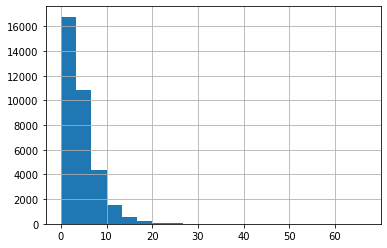

In [262]:
temp_df['temp_goodness'].hist(bins = 20)

### Catagories
Values in catagories can be changed and then applied to dataframe

In [263]:
# Function to assign grade scores
def assign_grade(metric_score):
    if metric_score <= excellent_score:
        return 'excellent'
    elif metric_score <= good_score:
        return 'good'
    elif metric_score <= fair_score:
        return 'fair'
    else:
        return 'poor'

In [264]:
# Applying the scores
temp_df['goodness_grade'] = temp_df['temp_goodness'].apply(lambda metric_score: assign_grade(metric_score))

# Group by Circles Now For Final Counts 
num - The number of stations for a circle for a count date

num_notna - The number of stations that are not null for their temp measurments


The next sections for "e_" and "n_" are the same as abouve, except e is only stations for a circle that
are in the same ecosystem and n is stations with the same nlcd code.




In [265]:
def temp_calc(dfg):
    is_na_max = dfg.max_bw_noaa.isna()
    is_na_min = dfg.min_bw_noaa.isna()

    # there can be weirdness with boolean not being promoted to ints, so add zero
    # Count the number of stations for this circle
    # Station temp present is true for is both min and max are present in the 
    # station data
    num = dfg.station_temp_present.size + 0
    # Count the number of stations where both temp mesurments are not NA 
    num_notna = dfg.station_temp_present.size + 0
    # Count the number of stations where the colunteer submitted average was between the NOAA min and max
    if dfg.min_bw_noaa.isnull().all():
        num_min_bw_noaa = np.NaN
    else:
        num_min_bw_noaa = dfg.min_bw_noaa.sum()
        
    if dfg.max_bw_noaa.isnull().all():
        num_max_bw_noaa = np.NaN
    else:
        num_max_bw_noaa = dfg.max_bw_noaa.sum()
        
    
    # Number of Stations with a 'each Classifyer'
    num_excellent = dfg.loc[dfg.goodness_grade == 'excellent'].shape[0]
    num_good = dfg.loc[dfg.goodness_grade == 'good'].shape[0]
    num_fair = dfg.loc[dfg.goodness_grade == 'fair'].shape[0]
    num_poor = dfg.loc[dfg.goodness_grade == 'poor'].shape[0]
    
    try: 
        goodness_mode = mode(dfg.goodness_grade.values.tolist())
    except: 
        goodness_mode = np.NaN
    
    

    
    ## BREAKDOWN By Ecosys 
    e = dfg.loc[dfg.same_ecosys]
    # Count the number of stations for this circle
    e_num = e.station_temp_present.size + 0
    # Count the number of stations where both temp mesurments are not NA 
    e_num_notna = e.station_temp_present.size + 0
    # Count the number of stations where the colunteer submitted average was between the NOAA min and max
    if e.min_bw_noaa.isnull().all():
        e_num_min_bw_noaa = np.NaN
    else:
        e_num_min_bw_noaa = e.min_bw_noaa.sum()
        
    if e.max_bw_noaa.isnull().all():
        e_num_max_bw_noaa = np.NaN
    else:
        e_num_max_bw_noaa = e.max_bw_noaa.sum()
    
    # Number of Stations with a 'each Classifyer'
    e_num_excellent = e.loc[dfg.goodness_grade == 'excellent'].shape[0]
    e_num_good = e.loc[e.goodness_grade == 'good'].shape[0]
    e_num_fair = e.loc[e.goodness_grade == 'fair'].shape[0]
    e_num_poor = e.loc[e.goodness_grade == 'poor'].shape[0]
    
    try: 
        e_goodness_mode = mode(e.goodness_grade.values.tolist())
    except: 
        e_goodness_mode = np.NaN
    
    
    ## BREAKDOWN By NCLD 
    n = dfg.loc[dfg.same_nlcd]
    # Count the number of stations for this circle
    n_num = n.station_temp_present.size + 0
    # Count the number of stations where both temp mesurments are not NA 
    n_num_notna = n.station_temp_present.size + 0
    # Count the number of stations where the colunteer submitted average was between the NOAA min and max
    if n.min_bw_noaa.isnull().all():
        n_num_min_bw_noaa = np.NaN
    else:
        n_num_min_bw_noaa = n.min_bw_noaa.sum()
        
    if n.max_bw_noaa.isnull().all():
        n_num_max_bw_noaa = np.NaN
    else:
        n_num_max_bw_noaa = n.max_bw_noaa.sum()
    
    # Number of Stations with a 'each Classifyer'
    n_num_excellent = n.loc[dfg.goodness_grade == 'excellent'].shape[0]
    n_num_good = n.loc[n.goodness_grade == 'good'].shape[0]
    n_num_fair = n.loc[n.goodness_grade == 'fair'].shape[0]
    n_num_poor = n.loc[n.goodness_grade == 'poor'].shape[0]
    
    try: 
        n_goodness_mode = mode(n.goodness_grade.values.tolist())
    except: 
        n_goodness_mode = np.NaN
    
#     # havent figured out how to inlinse this yet ...
    lowest_id = dfg.elevation_diff.idxmin() if (num > 0) else np.NaN

    try:
        lowest_id_na = dfg.loc[~is_na_max, 'elevation_diff'].idxmin() if ((num_notna > 0) and dfg.loc[~is_na_max, 'elevation_diff'].shape[0] > 0) else np.NaN
    except:
        lowest_id_na = np.NaN
        
        
    
    return pd.Series({
        'num' : num,
        'num_notna' : num_notna,
        'num_min_bw_noaa' : num_min_bw_noaa,
        'num_max_bw_noaa' : num_max_bw_noaa,
        'num_excellent' : num_excellent,
        'num_good' : num_good,
        'num_fair' : num_fair,
        'num_poor' : num_poor,
        'goodness_mode' : goodness_mode,
        
        'e_num' : e_num,
        'e_num_notna' : e_num_notna,
        'e_num_min_bw_noaa' : e_num_min_bw_noaa,
        'e_num_max_bw_noaa' : e_num_max_bw_noaa,
        'e_num_excellent' : e_num_excellent,
        'e_num_good' : e_num_good,
        'e_num_fair' : e_num_fair,
        'e_num_poor' : e_num_poor,
        'e_goodness_mode' : e_goodness_mode,
        
        
        'n_num' : n_num,
        'n_num_notna' : n_num_notna,
        'n_num_min_bw_noaa' : n_num_min_bw_noaa,
        'n_num_max_bw_noaa' : n_num_max_bw_noaa,
        'n_num_excellent' : n_num_excellent,
        'n_num_good' : n_num_good,
        'n_num_fair' : n_num_fair,
        'n_num_poor' : n_num_poor,
        'n_goodness_mode' : n_goodness_mode,
        

        'p' : num_max_bw_noaa / num_notna if (num_notna > 0) else np.NaN,
        'e_p' : e_num_max_bw_noaa / e_num_notna if (e_num_notna > 0) else np.NaN,
        'n_p' : n_num_max_bw_noaa / n_num_notna if (n_num_notna > 0) else np.NaN,
        
        
        # Goodness Closest 
        'goodness_closest' : dfg.loc[dfg.distance_diff.idxmin(), 'goodness_grade'] if (num > 0) else pd.NA,
        
        # Max Closest
        'max_temp_closest' : dfg.loc[dfg.distance_diff.idxmin(), 'max_bw_noaa'] if (num > 0) else pd.NA,
        'max_temp_closest_value' : dfg.loc[dfg.distance_diff.idxmin(), 'noaa_max_temp'] if (num > 0) else pd.NA,
        
        'max_temp_closest_notna' : dfg.loc[dfg.loc[~is_na_max, 'distance_diff'].idxmin(), 'max_bw_noaa'] if (num_notna > 0 and num_max_bw_noaa > 0 ) else pd.NA,
        
        # Min Closest
        'min_temp_closest' : dfg.loc[dfg.distance_diff.idxmin(), 'min_bw_noaa'] if (num > 0) else pd.NA,
        'min_temp_closest_value' : dfg.loc[dfg.distance_diff.idxmin(), 'noaa_min_temp'] if (num > 0) else pd.NA,
        
        'min_temp_closest_notna' : dfg.loc[dfg.loc[~is_na_min, 'distance_diff'].idxmin(), 'min_bw_noaa'] if (num_notna > 0 and num_min_bw_noaa > 0 ) else pd.NA,
        
        #Goodness Lowest
        'goodness_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 'goodness_grade'],
        
        # Max Lowest 
        'max_temp_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 'max_bw_noaa'],
        'max_temp_lowest_value' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 'noaa_max_temp'],
        'max_temp_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 'max_bw_noaa'],
        
        # Min Losest
        'min_temp_lowest' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 'min_bw_noaa'],
        'min_temp_lowest_value' : pd.NA if pd.isna(lowest_id) else dfg.loc[lowest_id, 'noaa_min_temp'],
        'min_temp_lowest_notna' : pd.NA if pd.isna(lowest_id_na) else dfg.loc[lowest_id_na, 'min_bw_noaa'],
    })


In [266]:
temp_df = temp_df.set_index(['circle_id', 'count_date', 'noaa_id']).sort_index()


In [267]:
g = temp_df.groupby(level=['circle_id', 'count_date'])

In [268]:
g

# The new fields used for Analysis
num - The number of stations for a circle for a count date 

num_notna - The number of stations that are not null for their max temp measurment 

num_min_bw_noaa, num_max_bw_noaa - The number of reference stations that bount the circle
reported min temp and max temp, respectivly. 

num_excellent, num_good, num_fair, num_poor - The number of stations thats goodness 
measure was in categories, excellent, good, far, ect 

goodness_mode - The goodness matric category that appears the most often for a circle 

num_min_bw_noaa - The number of stations where the cbc Min was within NOAA bounds 
num_min_bw_noaa - The number of stations where the cbc Max was within NOAA bounds

The next sections for "e_" and "n_" are the same as abouve, except e is only stations for a circle that
are in the same ecosystem and n is stations with the same nlcd code.

p - The proportion of stations that reported a max temp within bounds for a circle




In [274]:
# Compute the fields used for Analysis
circle_data = g.apply(temp_calc)

# Determine if there is Consensus amoung a Circle's Reference Stations
Using the AGREEMENT_THRESHOLD set at the top of the notebook, determine if the there are enough stations for
a circle agree that it rained based on that agreement threshold.

Do this for all stations and stations within the same ecosys and nlcd code 

In [276]:
# if the stations couldnt agree (p ∈ [1-AGREEMENT_THRESHOLD, AGREEMENT_THRESHOLD]) or p is NaN, set the consenus to NaN as well
circle_data['consensus'] = np.where(((circle_data.p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.p <= AGREEMENT_THRESHOLD)) | circle_data.p.isna(), 
                                     pd.NA, circle_data.p >= AGREEMENT_THRESHOLD)

circle_data['e_consensus'] = np.where(((circle_data.e_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.e_p <= AGREEMENT_THRESHOLD)) | circle_data.e_p.isna(), 
                                     pd.NA, circle_data.e_p >= AGREEMENT_THRESHOLD)

circle_data['n_consensus'] = np.where(((circle_data.n_p >= (1-AGREEMENT_THRESHOLD)) & (circle_data.n_p <= AGREEMENT_THRESHOLD)) | circle_data.n_p.isna(), 
                                     pd.NA, circle_data.n_p >= AGREEMENT_THRESHOLD)

---

In [277]:
for c in ['consensus', 'e_consensus', 'n_consensus','max_temp_closest', 'max_temp_closest_notna', 'max_temp_lowest', 'max_temp_lowest_notna']:
    circle_data[c] = circle_data[c].astype('boolean')
    


In [278]:
temp_df.head()

ui  count_year  \
circle_id count_date noaa_id                                          
87ymwsn   1968-12-26 USC00519130  22.0833-159.6667_1969        1969   
87ysunb   1971-12-27 US1HIKI0004  21.9667-159.4333_1972        1972   
                     US1HIKI0014  21.9667-159.4333_1972        1972   
                     US1HIKI0018  21.9667-159.4333_1972        1972   
                     USC00510006  21.9667-159.4333_1972        1972   

                                     circle_name  Ecosys_circle  \
circle_id count_date noaa_id                                      
87ymwsn   1968-12-26 USC00519130  Kaua'i: Waimea            NaN   
87ysunb   1971-12-27 US1HIKI0004  Kaua'i: Lihu'e            NaN   
                     US1HIKI0014  Kaua'i: Lihu'e            NaN   
                     US1HIKI0018  Kaua'i: Lihu'e            NaN   
                     USC00510006  Kaua'i: Lihu'e            NaN   

                                 specific_circle_ecosystem  Nlcd_code_circle  \
circle_id count_date noaa_id                                                   
87ymwsn   1968-12-26 USC00519130                       NaN               NaN   
87ysunb   1971-12-27 US1HIKI0004                       NaN               NaN   
                     US1HIKI0014                       NaN               NaN   
                     US1HIKI0018                       NaN               NaN   
                     USC00510006                       NaN               NaN   

                                 macro_circle_ecosystem  circle_elevation  \
circle_id count_date noaa_id                                                
87ymwsn   1968-12-26 USC00519130                    NaN           1015.74   
87ysunb   1971-12-27 US1HIKI0004                    NaN            142.96   
                     US1HIKI0014                    NaN            142.96   
                     US1HIKI0018                    NaN            142.96   
                     USC00510006                    NaN            142.96   

                                  circle_lat  circle_lon  circle_min_temp  \
circle_id count_date noaa_id                                                
87ymwsn   1968-12-26 USC00519130     22.0833   -159.6667        20.000000   
87ysunb   1971-12-27 US1HIKI0004     21.9667   -159.4333        23.333333   
                     US1HIKI0014     21.9667   -159.4333        23.333333   
                     US1HIKI0018     21.9667   -159.4333        23.333333   
                     USC00510006     21.9667   -159.4333        23.333333   

                                  circle_max_temp  Ecosys_station  \
circle_id count_date noaa_id                                        
87ymwsn   1968-12-26 USC00519130        25.555556             NaN   
87ysunb   1971-12-27 US1HIKI0004        25.555556             NaN   
                     US1HIKI0014        25.555556             NaN   
                     US1HIKI0018        25.555556             NaN   
                     USC00510006        25.555556             NaN   

                                 specific_station_ecosystem  \
circle_id count_date noaa_id                                  
87ymwsn   1968-12-26 USC00519130                        NaN   
87ysunb   1971-12-27 US1HIKI0004                        NaN   
                     US1HIKI0014                        NaN   
                     US1HIKI0018                        NaN   
                     USC00510006                        NaN   

                                  Nlcd_code_station macro_station_ecosystem  \
circle_id count_date noaa_id                                                  
87ymwsn   1968-12-26 USC00519130                NaN                     NaN   
87ysunb   1971-12-27 US1HIKI0004                NaN                     NaN   
                     US1HIKI0014                NaN                     NaN   
                     US1HIKI0018                NaN                     NaN   
                     USC00510006            

#### Merge is the circle recorded data with the summary dataframe

In [279]:
circle_obs = temp_df[['ui','circle_min_temp', 'circle_max_temp', 'circle_average_temp', 'Ecosys_station' ,'Nlcd_code_station']].groupby(['circle_id', 'count_date']).agg('first')


In [280]:
circle_data = circle_obs.join(circle_data)

In [281]:
circle_data.head()

ui  circle_min_temp  circle_max_temp  \
circle_id count_date                                                            
87ymwsn   1968-12-26  22.0833-159.6667_1969        20.000000        25.555556   
87ysunb   1971-12-27  21.9667-159.4333_1972        23.333333        25.555556   
          1972-12-17  21.9667-159.4333_1973        22.222222        25.555556   
          1973-12-16  21.9667-159.4333_1974        17.222222        27.777778   
          1974-12-15  21.9667-159.4333_1975        22.222222        27.777778   

                      circle_average_temp  Ecosys_station  Nlcd_code_station  \
circle_id count_date                                                           
87ymwsn   1968-12-26            22.777778             NaN                NaN   
87ysunb   1971-12-27            24.444444             NaN                NaN   
          1972-12-17            23.888889             NaN                NaN   
          1973-12-16            22.500000             NaN                NaN   
          1974-12-15            25.000000             NaN                NaN   

                      num  num_notna  num_min_bw_noaa  num_max_bw_noaa  \
circle_id count_date                                                     
87ymwsn   1968-12-26    1          1              0.0              0.0   
87ysunb   1971-12-27   13         13              0.0              0.0   
          1972-12-17   13         13              0.0              0.0   
          1973-12-16   13         13              0.0              0.0   
          1974-12-15   13         13              0.0              0.0   

                      num_excellent  num_good  num_fair  num_poor  \
circle_id count_date                                                
87ymwsn   1968-12-26              0         0         0         1   
87ysunb   1971-12-27              0         0         0        13   
          1972-12-17              0         0         0        13   
          1973-12-16              0         0         0        13   
          1974-12-15              0         0         0        13   

                     goodness_mode  e_num  e_num_notna  e_num_min_bw_noaa  \
circle_id count_date                                                        
87ymwsn   1968-12-26          poor      0            0                NaN   
87ysunb   1971-12-27          poor      0            0                NaN   
          1972-12-17          poor      0            0                NaN   
          1973-12-16          poor      0            0                NaN   
          1974-12-15          poor      0            0                NaN   

                      e_num_max_bw_noaa  e_num_excellent  e_num_good  \
circle_id count_date                                                   
87ymwsn   1968-12-26                NaN                0           0   
87ysunb   1971-12-27                NaN                0           0   
          1972-12-17                NaN                0           0   
          1973-12-16                NaN                0           0   
          1974-12-15                NaN                0           0   

                      e_num_fair  e_num_poor e_goodness_mode  n_num  \
circle_id count_date                                                  
87ymwsn   1968-12-26           0           0             NaN      0   
87ysunb   1971-12-27           0           0             NaN      0   
          1972-12-17           0           0             NaN      0   
          1973-12-16           0           0             NaN      0   
          1974-12-15           0           0             NaN      0   

                      n_num_notna  n_num_min_bw_noaa  n_num_max_bw_noaa  \
circle_id count_date                                                      
87ymwsn   1968-12-26            0                NaN                NaN   
87ysunb   1971-12-27            0                NaN                NaN   
          1972-12-17            0                NaN              

In [282]:
# Count the number of circles we have 
circle_data['ui'].nunique()

68390

### The number of stations per circle

In [283]:
circle_data.num.describe()

count    68390.000000
mean         6.025808
std          7.684488
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        101.000000
Name: num, dtype: float64

## The Missing Station and Circle Data

In [284]:
# Create an list of indexes with missing min OR max temp
circle_data_na_circle_idx = (circle_data.circle_min_temp.isna() | circle_data.circle_max_temp.isna())


In [285]:
print("Circles with missing Max or Min Temp Data: ")
print(circle_data_na_circle_idx.sum())
print("Circles with NO missing Temp Data: ")
print(len(circle_data) - circle_data_na_circle_idx.sum())

Circles with missing Max or Min Temp Data: 
10925
Circles with NO missing Temp Data: 
57465


In [286]:
# Quick Look at Missing Max Temp
circle_data_maxna_circle_idx = circle_data.circle_max_temp.isna()

In [287]:
print("Circles with missing MAX Temp Data: ")
print(circle_data_maxna_circle_idx.sum())
print("Circles with NO missing MAX Temp Data: ")
print(len(circle_data) - circle_data_maxna_circle_idx.sum())

Circles with missing MAX Temp Data: 
10919
Circles with NO missing MAX Temp Data: 
57471


In [288]:
# Quick Look at Missing Min Temp
circle_data_minna_circle_idx = circle_data.circle_min_temp.isna()

In [289]:
print("Circles with missing Min Temp Data: ")
print(circle_data_minna_circle_idx.sum())
print("Circles with NO missing Min Temp Data: ")
print(len(circle_data) - circle_data_minna_circle_idx.sum())

Circles with missing Min Temp Data: 
10895
Circles with NO missing Min Temp Data: 
57495


In [290]:
# Quick Look at Missing BOTH min and max temp
circle_data_bothna_circle_idx = (circle_data.circle_min_temp.isna() & circle_data.circle_max_temp.isna())


In [291]:
print("Circles with missing Temp Data: ")
print(circle_data_bothna_circle_idx.sum())
print("Circles with NO missing Temp Data: ")
print(len(circle_data) - circle_data_bothna_circle_idx.sum())

Circles with missing Temp Data: 
10889
Circles with NO missing Temp Data: 
57501


#### Count and Percent of Stations Reporting if the Circle Reported Temp Data

In [292]:
print("Stations with missing Temp Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna == 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Stations with NO missing Temp Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.num_notna != 0)].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Stations with missing Temp Data IF the the Circle is Reporting:
0
0.0
Stations with NO missing Temp Data IF the Circle is Reporting: 
57465
100.0


#### Count and Percent of Closest Stations Reporting if the Circle Reported Temp Data

In [293]:
print("Closest Stations with missing Max Temp Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.max_temp_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.max_temp_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Stations with NO missing Max Temp Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.max_temp_closest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.max_temp_closest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Stations with missing Max Temp Data IF the the Circle is Reporting:
0
0.0
Closest Stations with NO missing Max Temp Data IF the Circle is Reporting: 
57465
100.0


#### Count and Percent of Closest Elivation Stations Reporting if the Circle Reported Rain Data

In [294]:
print("Closest Elivation Stations with missing Max Temp Data IF the the Circle is Reporting:")
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.max_temp_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (circle_data.max_temp_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )
print("Closest Elivation Stations with NO missing Max Temp Data IF the Circle is Reporting: ")
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.max_temp_lowest.isna())].shape[0])
print(circle_data[(~circle_data_na_circle_idx) & (~circle_data.max_temp_lowest.isna())].shape[0] / len(circle_data[~circle_data_na_circle_idx]) * 100 )


Closest Elivation Stations with missing Max Temp Data IF the the Circle is Reporting:
241
0.41938571304272165
Closest Elivation Stations with NO missing Max Temp Data IF the Circle is Reporting: 
57224
99.58061428695729


# Circle v Station: The Final Determination on If Volenteers are Reliable

In [295]:
def crosstab_metrics(actl):
    # accuracy
    acc = actl.to_numpy().diagonal().sum() / actl.to_numpy().sum()
    # precision
    pr = actl.loc[1,1] / actl.to_numpy()[[1,0], [1,1]].sum()
    # recall
    re = actl.loc[1,1] / actl.to_numpy()[[1,1], [1,0]].sum()
    # F1
    f1 = 2 * pr * re / (pr + re)
    
    print(f"accuracy:  {acc*100:.2f}%")
    print(f"precision: {pr*100:.2f}%")
    print(f"recall:    {re*100:.2f}%")
    print(f"F1:        {f1*100:.2f}%")
    
#     return (acc, pr, re, f1)

### Based on the all Reference Stations for a CBC Circle

In [297]:
# Check that the Minimum and Maximun Values are within the NOAA bounds

print("Cicles where the circle Min temp is in bounds for NO references stations:")
print(((circle_data.num_min_bw_noaa / circle_data.num) == 0).sum())
print(((circle_data.num_min_bw_noaa / circle_data.num) == 0).sum() / circle_data.shape[0] * 1)
print("Cicles where the circle Min temp is in bounds for 0 to 50% matching references stations")
print((((circle_data.num_min_bw_noaa / circle_data.num) > 0) & ((circle_data.num_min_bw_noaa / circle_data.num) < .50)).sum())
print((((circle_data.num_min_bw_noaa / circle_data.num) > 0) & ((circle_data.num_min_bw_noaa / circle_data.num) < .50)).sum() / circle_data.shape[0] * 100)
print("Cicles where the circle Min temp is in bounds for  50% to All matching references stations")
print((((circle_data.num_min_bw_noaa / circle_data.num) < 1) & ((circle_data.num_min_bw_noaa / circle_data.num) >= .50)).sum())
print((((circle_data.num_min_bw_noaa / circle_data.num) < 1) & ((circle_data.num_min_bw_noaa / circle_data.num) >= .50)).sum() / circle_data.shape[0] * 100)
print("Cicles where the circle Min temp is in bounds for ALL references stations: ")
print(((circle_data.num_min_bw_noaa / circle_data.num) == 1).sum())
print(((circle_data.num_min_bw_noaa / circle_data.num) == 1).sum() / circle_data.shape[0] * 1)


Cicles where the circle Min temp is in bounds for NO references stations:
39160
0.572598333089633
Cicles where the circle Min temp is in bounds for 0 to 50% matching references stations
14132
20.663839742652435
Cicles where the circle Min temp is in bounds for  50% to All matching references stations
2502
3.658429594970025
Cicles where the circle Min temp is in bounds for ALL references stations: 
1701
0.024872057318321393


In [300]:
# Check that the maximum and Maximun Values are within the NOAA bounds

print("Circles where the circle max temp is in bounds for NO references stations:")
print(((circle_data.num_max_bw_noaa / circle_data.num) == 0).sum())
print(((circle_data.num_max_bw_noaa / circle_data.num) == 0).sum() / circle_data.shape[0] * 100)
print("Cicles where the circle max temp is in bounds for 0 to 50% matching references stations")
print((((circle_data.num_max_bw_noaa / circle_data.num) > 0) & ((circle_data.num_max_bw_noaa / circle_data.num) < .50)).sum())
print((((circle_data.num_max_bw_noaa / circle_data.num) > 0) & ((circle_data.num_max_bw_noaa / circle_data.num) < .50)).sum() / circle_data.shape[0] * 100)
print("Cicles where the circle max temp is in bounds for  50% to All matching references stations")
print((((circle_data.num_max_bw_noaa / circle_data.num) < 1) & ((circle_data.num_max_bw_noaa / circle_data.num) >= .50)).sum())
print((((circle_data.num_max_bw_noaa / circle_data.num) < 1) & ((circle_data.num_max_bw_noaa / circle_data.num) >= .50)).sum() / circle_data.shape[0] * 100)
print("Cicles where the circle max temp is in bounds for ALL references stations: ")
print(((circle_data.num_max_bw_noaa / circle_data.num) == 1).sum())
print(((circle_data.num_max_bw_noaa / circle_data.num) == 1).sum() / circle_data.shape[0] * 100)


Circles where the circle max temp is in bounds for NO references stations:
40798
59.654920309986835
Cicles where the circle max temp is in bounds for 0 to 50% matching references stations
13008
19.020324608860946
Cicles where the circle max temp is in bounds for  50% to All matching references stations
2163
3.1627430910951895
Cicles where the circle max temp is in bounds for ALL references stations: 
1502
2.1962275186430764


### Deep Dive on if Max Temperture Is In Bounds of Their Reference Stations

In [302]:
circle_data.head()

ui  circle_min_temp  circle_max_temp  \
circle_id count_date                                                            
87ymwsn   1968-12-26  22.0833-159.6667_1969        20.000000        25.555556   
87ysunb   1971-12-27  21.9667-159.4333_1972        23.333333        25.555556   
          1972-12-17  21.9667-159.4333_1973        22.222222        25.555556   
          1973-12-16  21.9667-159.4333_1974        17.222222        27.777778   
          1974-12-15  21.9667-159.4333_1975        22.222222        27.777778   

                      circle_average_temp  Ecosys_station  Nlcd_code_station  \
circle_id count_date                                                           
87ymwsn   1968-12-26            22.777778             NaN                NaN   
87ysunb   1971-12-27            24.444444             NaN                NaN   
          1972-12-17            23.888889             NaN                NaN   
          1973-12-16            22.500000             NaN                NaN   
          1974-12-15            25.000000             NaN                NaN   

                      num  num_notna  num_min_bw_noaa  num_max_bw_noaa  \
circle_id count_date                                                     
87ymwsn   1968-12-26    1          1              0.0              0.0   
87ysunb   1971-12-27   13         13              0.0              0.0   
          1972-12-17   13         13              0.0              0.0   
          1973-12-16   13         13              0.0              0.0   
          1974-12-15   13         13              0.0              0.0   

                      num_excellent  num_good  num_fair  num_poor  \
circle_id count_date                                                
87ymwsn   1968-12-26              0         0         0         1   
87ysunb   1971-12-27              0         0         0        13   
          1972-12-17              0         0         0        13   
          1973-12-16              0         0         0        13   
          1974-12-15              0         0         0        13   

                     goodness_mode  e_num  e_num_notna  e_num_min_bw_noaa  \
circle_id count_date                                                        
87ymwsn   1968-12-26          poor      0            0                NaN   
87ysunb   1971-12-27          poor      0            0                NaN   
          1972-12-17          poor      0            0                NaN   
          1973-12-16          poor      0            0                NaN   
          1974-12-15          poor      0            0                NaN   

                      e_num_max_bw_noaa  e_num_excellent  e_num_good  \
circle_id count_date                                                   
87ymwsn   1968-12-26                NaN                0           0   
87ysunb   1971-12-27                NaN                0           0   
          1972-12-17                NaN                0           0   
          1973-12-16                NaN                0           0   
          1974-12-15                NaN                0           0   

                      e_num_fair  e_num_poor e_goodness_mode  n_num  \
circle_id count_date                                                  
87ymwsn   1968-12-26           0           0             NaN      0   
87ysunb   1971-12-27           0           0             NaN      0   
          1972-12-17           0           0             NaN      0   
          1973-12-16           0           0             NaN      0   
          1974-12-15           0           0             NaN      0   

                      n_num_notna  n_num_min_bw_noaa  n_num_max_bw_noaa  \
circle_id count_date                                                      
87ymwsn   1968-12-26            0                NaN                NaN   
87ysunb   1971-12-27            0                NaN                NaN   
          1972-12-17            0                NaN              

### Maximum Temperture In bounds of NOAA Stations

In [303]:
print("Temp Data Consensus Amoung All Stations where the Circle Reported Max Temp was within bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == True].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == True].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == True]) * 100))

print("Temp Data Amoung Closest Stations where the Circle Reported Max Temp Between Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == True].max_temp_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == True].max_temp_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == True]) * 100))

print("Snow Data Amoung Closest in Elivation Stations where the Circle Max Temp is within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == True].max_temp_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == True].max_temp_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Max Temp is within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == True].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == True].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same ecosys classification where the Circle Max Temp is within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == True].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == True].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == True]) * 100))



Temp Data Consensus Amoung All Stations where the Circle Reported Max Temp was within bounds:
False    8235
NaN      4848
True     1367
Name: consensus, dtype: Int64
^^ with Percentage:
False    56.989619
NaN      33.550173
True      9.460208
Name: consensus, dtype: float64
Temp Data Amoung Closest Stations where the Circle Reported Max Temp Between Bounds:
False    9908
True     4542
NaN         0
Name: max_temp_closest, dtype: Int64
^^ with Percentage:
False    68.567474
True     31.432526
NaN       0.000000
Name: max_temp_closest, dtype: float64
Snow Data Amoung Closest in Elivation Stations where the Circle Max Temp is within Bounds:
False    9845
True     4528
NaN        77
Name: max_temp_lowest, dtype: Int64
^^ with Percentage:
False    68.131488
True     31.335640
NaN       0.532872
Name: max_temp_lowest, dtype: float64
Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Max Temp is within Bounds:
NaN      7609
False    4775
True     2066
Name: n_consens

In [304]:

print("Temp Data Consensus Amoung All Stations where the Circle did NOT Report Max Temp within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == False].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == False].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == False]) * 100))

print("Temp Data Amoung Closest Stations where the Circle did NOT Report Max Temp within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == False].max_temp_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == False].max_temp_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == False]) * 100))

print("Temp Data Amoung Closest in Elivation Stations where the Circle did NOT Report Max Temp within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == False].max_temp_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == False].max_temp_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == False]) * 100))

print("Temp Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Max Temp within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == False].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == False].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == False]) * 100))

print("Temp Data Consensus Amoung Stations with the same ecosys classification where the Circle did NOT Report Max Temp within Bounds:")
print(circle_data.loc[circle_data['num_max_bw_noaa'] == False].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_max_bw_noaa'] == False].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_max_bw_noaa'] == False]) * 100))




Temp Data Consensus Amoung All Stations where the Circle did NOT Report Max Temp within Bounds:
False    40798
NaN          0
Name: consensus, dtype: Int64
^^ with Percentage:
False    100.0
NaN        0.0
Name: consensus, dtype: float64
Temp Data Amoung Closest Stations where the Circle did NOT Report Max Temp within Bounds:
False    40798
NaN          0
Name: max_temp_closest, dtype: Int64
^^ with Percentage:
False    100.0
NaN        0.0
Name: max_temp_closest, dtype: float64
Temp Data Amoung Closest in Elivation Stations where the Circle did NOT Report Max Temp within Bounds:
False    40639
NaN        159
Name: max_temp_lowest, dtype: Int64
^^ with Percentage:
False    99.610275
NaN       0.389725
Name: max_temp_lowest, dtype: float64
Temp Data Consensus Amoung Stations with the same nlcd code where the Circle did NOT Report Max Temp within Bounds:
False    24082
NaN      16716
Name: n_consensus, dtype: Int64
^^ with Percentage:
False    59.027403
NaN      40.972597
Name: n_consens

### Minimum Temperture In bounds of NOAA Stations

In [305]:
print("Temp Data Consensus Amoung All Stations where the Circle Reported Min Temp was within bounds:")
print(circle_data.loc[circle_data['num_min_bw_noaa'] == True].consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_min_bw_noaa'] == True].consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_min_bw_noaa'] == True]) * 100))

print("Temp Data Amoung Closest Stations where the Circle Reported Min Temp Between Bounds:")
print(circle_data.loc[circle_data['num_min_bw_noaa'] == True].min_temp_closest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_min_bw_noaa'] == True].min_temp_closest.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_min_bw_noaa'] == True]) * 100))

print("Snow Data Amoung Closest in Elivation Stations where the Circle Min Temp is within Bounds:")
print(circle_data.loc[circle_data['num_min_bw_noaa'] == True].min_temp_lowest.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_min_bw_noaa'] == True].min_temp_lowest.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_min_bw_noaa'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Min Temp is within Bounds:")
print(circle_data.loc[circle_data['num_min_bw_noaa'] == True].n_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_min_bw_noaa'] == True].n_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_min_bw_noaa'] == True]) * 100))

print("Snow Data Consensus Amoung Stations with the same ecosys classification where the Circle Min Temp is within Bounds:")
print(circle_data.loc[circle_data['num_min_bw_noaa'] == True].e_consensus.value_counts(dropna = False) )
print("^^ with Percentage:")
print((circle_data.loc[circle_data['num_min_bw_noaa'] == True].e_consensus.value_counts(dropna = False) / len(circle_data.loc[circle_data['num_min_bw_noaa'] == True]) * 100))



Temp Data Consensus Amoung All Stations where the Circle Reported Min Temp was within bounds:
False    11839
NaN       3019
True       858
Name: consensus, dtype: Int64
^^ with Percentage:
False    75.330873
NaN      19.209723
True      5.459404
Name: consensus, dtype: float64
Temp Data Amoung Closest Stations where the Circle Reported Min Temp Between Bounds:
0.0    10748
1.0     4968
Name: min_temp_closest, dtype: int64
^^ with Percentage:
0.0    68.388903
1.0    31.611097
Name: min_temp_closest, dtype: float64
Snow Data Amoung Closest in Elivation Stations where the Circle Min Temp is within Bounds:
0.0    10659
1.0     4969
NaN       88
Name: min_temp_lowest, dtype: int64
^^ with Percentage:
0.0    67.822601
1.0    31.617460
NaN     0.559939
Name: min_temp_lowest, dtype: float64
Snow Data Consensus Amoung Stations with the same nlcd code where the Circle Min Temp is within Bounds:
False    7547
NaN      6872
True     1297
Name: n_consensus, dtype: Int64
^^ with Percentage:
False   

## Population Compasison 
Compare the opulations of the Max Temps reported by the cbc circles and the Max temps recorded by the NOAA circles 

In [313]:
# Set up the two populations
cbc_max_temps = circle_data['circle_max_temp']
noaa_max_temps = circle_data['max_temp_closest_value']

print("The number of cases for CBC Max Temps is: " + str(cbc_max_temps.shape[0]))
print("The number of cases for NOAA Max Temps is: " + str(noaa_max_temps.shape[0]))

The number of cases for CBC Max Temps is: 68390
The number of cases for NOAA Max Temps is: 68390


In [314]:
# drop the Nan Values 
cbc_max_temps = cbc_max_temps.dropna()
noaa_max_temps = noaa_max_temps.dropna()

print("The number of cases for CBC Max Temps is: " + str(cbc_max_temps.shape[0]))
print("The number of cases for NOAA Max Temps is: " + str(noaa_max_temps.shape[0]))

The number of cases for CBC Max Temps is: 57471
The number of cases for NOAA Max Temps is: 18466


In [315]:
cbc_max_temps.describe()

count    57471.000000
mean         5.589304
std          9.684150
min        -45.000000
25%         -0.555556
50%          4.444444
75%         12.222222
max         56.000000
Name: circle_max_temp, dtype: float64

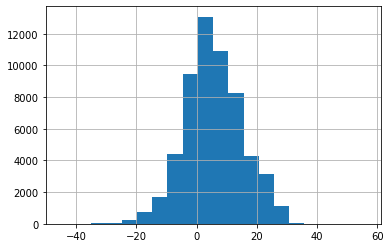

In [316]:
cbc_max_temps.hist(bins =20)

In [317]:
noaa_max_temps.describe()

count    18466.000000
mean         5.931729
std          8.994429
min        -35.600000
25%          0.000000
50%          5.000000
75%         11.700000
max         33.900000
Name: max_temp_closest_value, dtype: float64

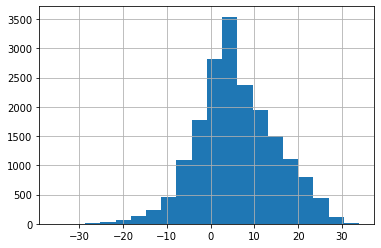

In [318]:
noaa_max_temps.hist(bins = 20)

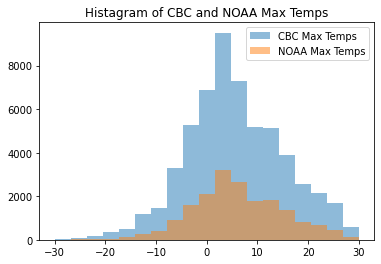

In [319]:
import random
import numpy
from matplotlib import pyplot

x = cbc_max_temps.tolist()
y = noaa_max_temps.tolist()

bins = numpy.linspace(-30, 30, 20)

pyplot.hist(x, bins, alpha=0.5, label='CBC Max Temps')
pyplot.hist(y, bins, alpha=0.5, label='NOAA Max Temps')
pyplot.legend(loc='upper right')
pyplot.title("Histagram of CBC and NOAA Max Temps")
pyplot.show()

#### Preform a two sample T Test 

In [321]:
scipy.stats.ttest_ind(cbc_max_temps.tolist(), noaa_max_temps.tolist(), equal_var=False)

Ttest_indResult(statistic=-4.415955625255944, pvalue=1.0088112774678262e-05)

# Goodness Metric for Max and Min Temp points 

In [334]:
# The Closest Stations' Goodness metric was, 
print("The goodness Metric of the closest stations were: ")
print(circle_data.goodness_closest.value_counts(dropna = False))
print("The goodness Metric of the closest stations as percentage: ")
print(circle_data.goodness_closest.value_counts(dropna = False) / circle_data.goodness_closest.size * 100)

The goodness Metric of the closest stations were: 
poor         59144
excellent     6003
good          2639
fair           604
Name: goodness_closest, dtype: int64
The goodness Metric of the closest stations as percentage: 
poor         86.480480
excellent     8.777599
good          3.858751
fair          0.883170
Name: goodness_closest, dtype: float64


In [335]:
# The Lowesr Stations' Goodness metric was, 
print("The goodness Metric of the closest stations were: ")
print(circle_data.goodness_lowest.value_counts(dropna = False))
print("The goodness Metric of the closest stations as percentage: ")
print(circle_data.goodness_lowest.value_counts(dropna = False) / circle_data.goodness_lowest.size * 100)


The goodness Metric of the closest stations were: 
poor         58929
excellent     6062
good          2535
fair           602
NaN            262
Name: goodness_lowest, dtype: int64
The goodness Metric of the closest stations as percentage: 
poor         86.166106
excellent     8.863869
good          3.706682
fair          0.880246
NaN           0.383097
Name: goodness_lowest, dtype: float64


In [336]:
# The Mode of all Stations for for each Circles were
print("The goodness Metric of ALL stations were: ")
print(circle_data.goodness_mode.value_counts(dropna = False))
print("The goodness Metric of the closest stations as percentage: ")
print(circle_data.goodness_mode.value_counts(dropna = False) / circle_data.goodness_mode.size * 100)


The goodness Metric of ALL stations were: 
poor         61828
NaN           3515
excellent     2040
good           809
fair           198
Name: goodness_mode, dtype: int64
The goodness Metric of the closest stations as percentage: 
poor         90.405030
NaN           5.139640
excellent     2.982892
good          1.182921
fair          0.289516
Name: goodness_mode, dtype: float64


In [337]:
# The Mode of all NLCD Stations for for each Circles were
print("The goodness Metric of NLCD stations were: ")
print(circle_data.n_goodness_mode.value_counts(dropna = False))
print("The goodness Metric of the closest stations as percentage: ")
print(circle_data.n_goodness_mode.value_counts(dropna = False) / circle_data.n_goodness_mode.size * 100)


The goodness Metric of NLCD stations were: 
poor         33962
NaN          29820
excellent     3104
good          1232
fair           272
Name: n_goodness_mode, dtype: int64
The goodness Metric of the closest stations as percentage: 
poor         49.659307
NaN          43.602866
excellent     4.538675
good          1.801433
fair          0.397719
Name: n_goodness_mode, dtype: float64


In [338]:
# The Mode of all ECOSYS Stations for for each Circles were
print("The goodness Metric of NLCD stations were: ")
print(circle_data.e_goodness_mode.value_counts(dropna = False))
print("The goodness Metric of the closest stations as percentage: ")
print(circle_data.e_goodness_mode.value_counts(dropna = False) / circle_data.e_goodness_mode.size * 100)


The goodness Metric of NLCD stations were: 
NaN          36555
poor         27484
excellent     2945
good          1157
fair           249
Name: e_goodness_mode, dtype: int64
The goodness Metric of the closest stations as percentage: 
NaN          53.450797
poor         40.187162
excellent     4.306185
good          1.691768
fair          0.364088
Name: e_goodness_mode, dtype: float64


---

## Ecosytem Grading Mapping

In [323]:
# Defining 
def grade_figure(fig_df):
    # Setting text for mouse overlay
    fig_df['text'] = 'Circle Name: ' + fig_df['circle_name'] + '<br>Goodness Grade: ' + fig_df['goodness_grade']
    
    # Generating figure
    fig = go.Figure(go.Scattergeo())

    # Trace layer for poor grading
    fig_poor = go.Scattergeo(
    locationmode = 'USA-states',
            lon = fig_df.loc[fig_df['goodness_grade'] == 'poor']['circle_lon'],
            lat = fig_df.loc[fig_df['goodness_grade'] == 'poor']['circle_lat'],
            text = fig_df.loc[fig_df['goodness_grade'] == 'poor']['text'], # Used for interactive map
            mode = 'markers',
            marker = dict(
                size = 2,
                opacity = .2,
                color = 'red'
            ),
            )
    
    # Trace layer for fair grading
    fig_fair = go.Scattergeo(
    locationmode = 'USA-states',
            lon = fig_df.loc[fig_df['goodness_grade'] == 'fair']['circle_lon'],
            lat = fig_df.loc[fig_df['goodness_grade'] == 'fair']['circle_lat'],
            text = fig_df.loc[fig_df['goodness_grade'] == 'fair']['text'], # Used for interactive map
            mode = 'markers',
            marker = dict(
                size = 4,
                opacity = .4,
                color = 'yellow'
            ),
            )
    
    # Trace layer for good grading
    fig_good = go.Scattergeo(
    locationmode = 'USA-states',
            lon = fig_df.loc[fig_df['goodness_grade'] == 'good']['circle_lon'],
            lat = fig_df.loc[fig_df['goodness_grade'] == 'good']['circle_lat'],
            text = fig_df.loc[fig_df['goodness_grade'] == 'good']['text'], # Used for interactive map
            mode = 'markers',
            marker = dict(
                size = 6,
                opacity = .8,
                color = 'blue'
            ),
            )
    
    # Trace layer for excellent grading
    fig_excellent = go.Scattergeo(
    locationmode = 'USA-states',
            lon = fig_df.loc[fig_df['goodness_grade'] == 'excellent']['circle_lon'],
            lat = fig_df.loc[fig_df['goodness_grade'] == 'excellent']['circle_lat'],
            text = fig_df.loc[fig_df['goodness_grade'] == 'excellent']['text'], # Used for interactive map
            mode = 'markers',
            marker = dict(
                size = 8,
                opacity = 1,
                color = 'chartreuse'
            ),
            )

    fig.add_trace(fig_poor)
    fig.add_trace(fig_fair)
    fig.add_trace(fig_good)
    fig.add_trace(fig_excellent)

    fig.update_layout(
            geo_scope='usa',
            showlegend=False
        )
    # Figures can slow down notebook so commenting out for review
    # fig.show()
    
    # Comment out below if you don't want to save the image
    # fig.write_image(f'{[x for x in globals() if globals()[x] is fig_df][0]}_temp_grade_geoscatter.png', scale = 5) #List comprehension pulls matching dataframe name from global ojects list

#### Specific Ecosystems

In [324]:
grade_figure(temp_df_specific_ecosystems)

NameError: name 'temp_df_specific_ecosystems' is not defined

#### Macro Ecosystems

In [ ]:
grade_figure(temp_df_macro_ecosystems)